In [1]:
%pip install seaborn

Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/avx2, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic/seaborn-0.12.2+computecanada-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


Following the tutorial on imbalanced data by Tensorflow here: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

2023-07-05 12:31:59.313325: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-05 12:32:01.487914: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 12:32:21.814703: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Check for GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Create data generator
datagen = ImageDataGenerator(
  rescale=1/255,
  preprocessing_function=preprocess_input
)
  
# Training dataset
train_ds = datagen.flow_from_directory(
  '/scratch/jhowe4/outputs/GDC/paad_example2/train',
  target_size=(224, 224),
  class_mode='binary',
  batch_size=32
)
  
# Testing dataset
test_ds = datagen.flow_from_directory(
  '/scratch/jhowe4/outputs/GDC/paad_example2/test',
  target_size=(224, 224),
  class_mode='binary',
  batch_size=32
)
  
# Validation dataset
valid_ds = datagen.flow_from_directory(
  '/scratch/jhowe4/outputs/GDC/paad_example2/valid',
  target_size=(224, 224),
  class_mode='binary',
  batch_size=32
)

Found 32434 images belonging to 2 classes.
Found 1363 images belonging to 2 classes.
Found 3880 images belonging to 2 classes.


### Define the model and the metrics
Define a function that creates a simple transfer learning model for binary classification

In [4]:
METRICS = [
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR') # Precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = tf.keras.Sequential()
    
    # Add ResNet50 model
    model.add(tf.keras.applications.ResNet50(include_top = False, pooling = 'avg', weights ='imagenet'))
  
    # Add outer classification layer to model
    model.add(tf.keras.layers.Dense(1, activation = 'sigmoid', bias_initializer=output_bias))
  
    # Not training the resnet on the new data set. Using the pre-trained weigths
    model.layers[0].trainable = False 
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )
    
    return model

2023-07-05 13:22:41.027143: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13509 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:87:00.0, compute capability: 7.5


### Baseline Model
Make and train the model using the function define above

In [5]:
import math
EPOCHS = 10
BATCH_SIZE = 256
NUM_TRAINING_TILES = 32434
NUM_VALID_TILES = 3880
STEPS_PER_EPOCH = math.ceil(NUM_TRAINING_TILES / BATCH_SIZE)
VALIDATION_STEPS = math.ceil(NUM_VALID_TILES / BATCH_SIZE)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True
)

model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


Test run the model

In [25]:
# Find the prevalence of each class in the test dataset
pos = 0
neg = 0
num_batches = len(train_ds)
for batch_idx in range(num_batches):
    _, batch_labels = train_ds[batch_idx]
    for label in batch_labels:
        if label == 1:
            pos = pos + 1
        elif label == 0:
            neg = neg + 1

total = pos + neg
print(f"Number of Positive Samples: {pos}\nNumber of Negative Samples: {neg}")
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}
print('Weight for class 0: {:.2f}' .format(weight_for_0))
print('Weight for class 1: {:.2f}' .format(weight_for_1))

KeyboardInterrupt: 

Set the correct initial bias

In [6]:
pos = 28883
neg = 3551
initial_bias = np.log([pos / neg])
initial_bias

# Checkpoint the initial weights
model = make_model(output_bias=initial_bias)
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

Confirm that the bias helps

In [11]:
# Zero bias model
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=valid_ds,
    validation_steps=VALIDATION_STEPS,
    verbose=1
)

# Bias model
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=valid_ds,
    validation_steps=VALIDATION_STEPS,
    verbose=1
)

colors = ['violet', 'mediumspringgreen']

def plot_loss(history, label, n):
    # Use a log scale on y-axis to show the wide range of values
    plt.semilogy(history.epoch, history.history['loss'], color=colors[n], label=f"Train {label}")
    plt.semilogy(history.epoch, history.history['val_loss'], color=colors[n], label=f"Val {label}", linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
plot_loss(zero_bias_history, 'Zero Bias', 0)
plot_loss(careful_bias_history, 'Careful Bias', 1)

Epoch 1/10


2023-07-04 08:49:29.014455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 19/127 [===>..........................] - ETA: 7:25 - loss: 0.4638 - tp: 1009.0000 - fp: 144.0000 - tn: 5.0000 - fn: 26.0000 - accuracy: 0.8564 - precision: 0.8751 - recall: 0.9749 - auc: 0.4865 - prc: 0.8632

KeyboardInterrupt: 

### Train the Model

In [ ]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[early_stopping],
    validation_data=valid_ds,
    validation_steps=VALIDATION_STEPS
)
model.save_weights('weights.h5')

Epoch 1/10


2023-07-05 13:24:34.958936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


### Check Training History
Make a plot of the model's accuracy and loss on the training and validation set

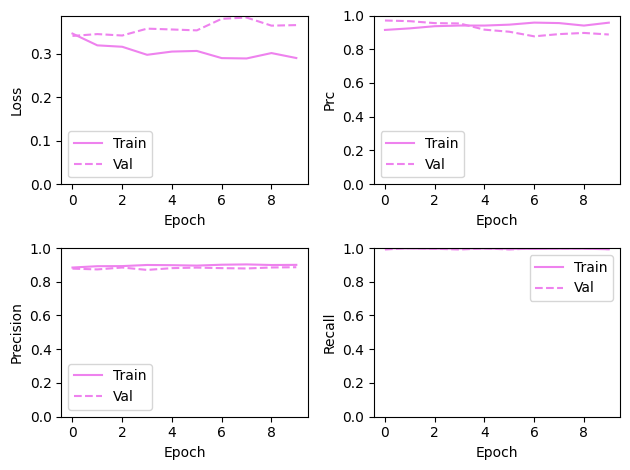

In [14]:
colors = ['violet', 'mediumspringgreen']
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    plt.tight_layout()
    
plot_metrics(baseline_history)
plt.savefig('../img/plot_metrics.pdf')

In [ ]:
# Evaluate metrics
train_predictions_baseline = model.predict(train_ds, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_ds, batch_size=BATCH_SIZE)

2023-07-05 11:28:43.268456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1014/1014 [==============================] - 2607s 3s/step


2023-07-05 12:13:07.349142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


43/43 [==============================] - 98s 2s/step


In [ ]:
# Get training and testing labels
def extract_labels(ds):
  labels = []
  num_batches = len(ds)
  for batch_idx in range(num_batches):
    _, batch_labels = ds[batch_idx]
    labels.extend(batch_labels)
  
  labels = np.array(labels)
  return labels 

train_labels = extract_labels(train_ds)
test_labels = extract_labels(test_ds)

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
    
    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5, 20])
    plt.ylim([20, 100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');